In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime
import os
from LocalUtilities.WriteToInflux import vehicles
from LocalUtilities.MakeDataframe import makeDataframe

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12, 6)

rootPath = r"C:\Users\ortun\OneDrive\PURDUE\CLASSES\ECE695\PROJECT\CODE\DATA"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def avgTimestamp(timestampList):
    return int(sum(timestampList) / len(timestampList))

In [206]:
j = 0

ID = vehicles[j]['id']
make = vehicles[j]['make']
model = vehicles[j]['model']
year = vehicles[j]['year']

In [207]:
path = "{}\{} {} {}".format(rootPath, make, model, year)
files = os.listdir(path)

In [208]:
df = pd.DataFrame()

for i in range(len(files)):
    with open(path + '\{}'.format(files[i]), 'r') as myFile:
        try:
            dataList = myFile.read().split('\n')
            dfi = makeDataframe(dataList)
            df = df.append(dfi)
            print('{}/{}'.format(i, len(files)))
        except:
            print('Unable to add {}/{}'.format(i, len(files)))

0/14
1/14
2/14
Unable to add 3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14


In [211]:
dfo = df.copy()

In [212]:
correlation_matrix = df.corr()

<AxesSubplot: xlabel='ChannelName', ylabel='ChannelName'>

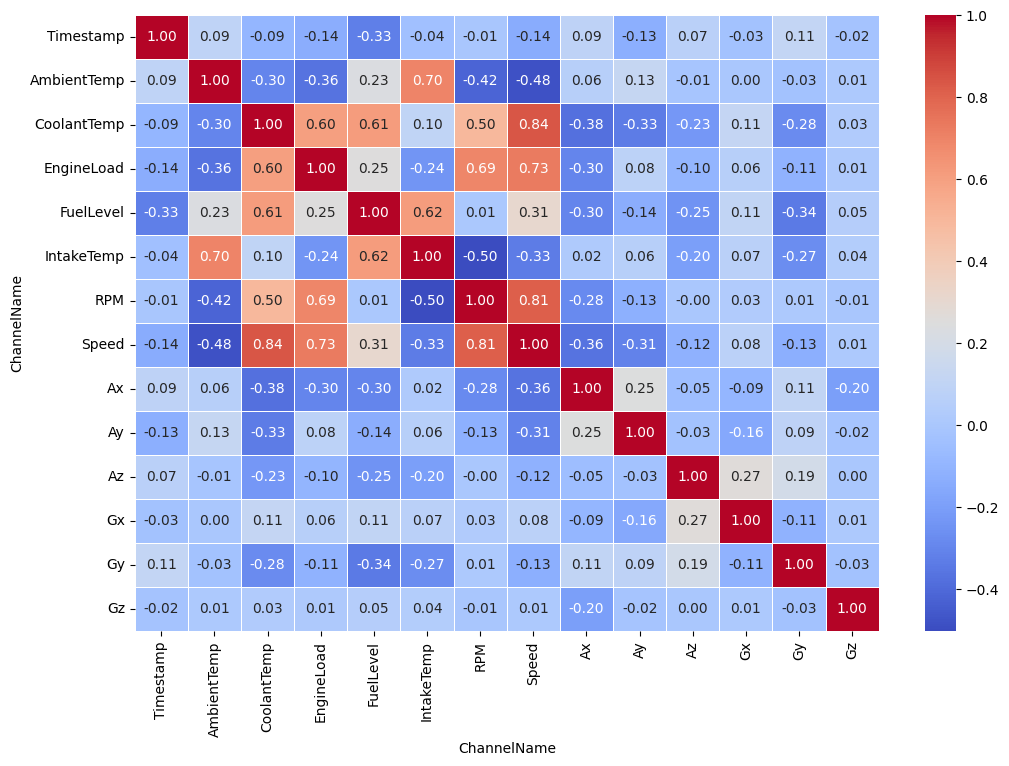

In [148]:
plt.figure(figsize=(12, 8))  # Set the figure size (optional)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [213]:
df = df[['EngineLoad','AirFlowRate','RPM', 'Speed', 'ThrottlePosition','Ay']].reset_index(drop=True)
# df = df[['EngineLoad','CoolantTemp','RPM', 'Speed','Ay']].reset_index(drop=True)


# Train model

In [214]:
features = ['AirFlowRate','RPM','Speed','ThrottlePosition','Ay']
# features = ['RPM','Speed','CoolantTemp']

X = df[features]
y = df['EngineLoad']

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
model = LinearRegression()

In [217]:
model.fit(X_train, y_train)

LinearRegression()

In [218]:
y_pred = model.predict(X_test)

In [219]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 125.11952582971122
R-squared: 0.7687015063050593


# Test model

In [220]:
intercept = model.intercept_
coefficients = model.coef_
c_d = {key: value for key, value in zip(features, coefficients)}

In [222]:
i = 1

with open(path + '\{}'.format(files[i]), 'r') as myFile:
    try:
        dataList = myFile.read().split('\n')
        dfi = makeDataframe(dataList)
        print('{}/{}'.format(i, len(files)))
    except:
        print('Unable to add {}/{}'.format(i, len(files)))

1/14


In [223]:
dfi = dfi[['EngineLoad','AirFlowRate','RPM','Speed','ThrottlePosition','Ay']]
# dfi = dfi[['EngineLoad','RPM','Speed','CoolantTemp']]

In [224]:
c_d

{'AirFlowRate': 1.3089431525393767,
 'RPM': -0.009490071753189501,
 'Speed': 0.04725941689698129,
 'ThrottlePosition': 0.856912442260779,
 'Ay': 69.1489141747624}

In [225]:
def predict(airflow, rpm, speed, throttle, ay):
    return intercept + airflow*c_d['AirFlowRate'] + rpm*c_d['RPM'] + speed*c_d['Speed'] + c_d['ThrottlePosition']*throttle + c_d['Ay']*ay

def predict_tiguan(coolant, rpm, speed):
    return intercept + coolant*c_d['CoolantTemp'] + rpm*c_d['RPM'] + speed*c_d['Speed']

In [226]:
dfi['EngineLoad_pred'] = dfi.apply(lambda row:predict(row['AirFlowRate'], row['RPM'], row['Speed'], row['ThrottlePosition'], row['Ay']), axis=1)
# dfi['EngineLoad_pred'] = dfi.apply(lambda row:predict_tiguan(row['CoolantTemp'], row['RPM'], row['Speed']), axis=1)

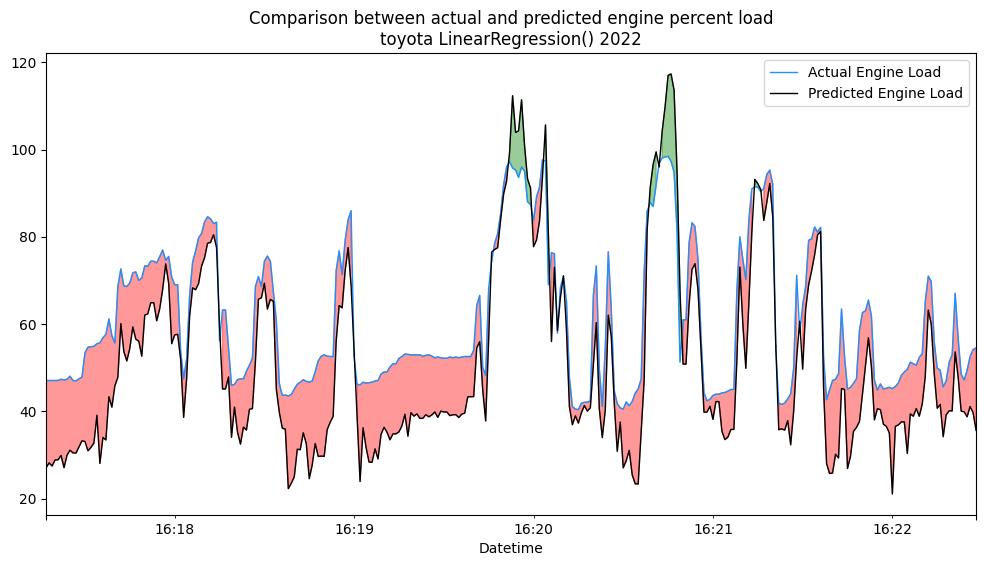

In [227]:
rollingWindow = 1

y1 = dfi['EngineLoad'].rolling(rollingWindow).mean()
y2 = dfi['EngineLoad_pred'].rolling(rollingWindow).mean()

y1.plot(label='Actual Engine Load', color='dodgerblue', linewidth=1)
y2.plot(label='Predicted Engine Load', color='black', linewidth=1)

plt.fill_between(dfi.index, y1, y2, where=(y1 > y2), color='red', alpha=0.4)
plt.fill_between(dfi.index, y2, y1, where=(y1 < y2), color='green', alpha=0.4)


plt.title('Comparison between actual and predicted engine percent load\n{} {} {}'.format(make, model, year))
plt.ylim = (0,100)
plt.legend()